In [3]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

#######
c_km = 3e8/1000

# Axion mass
m_a = 3e-6
m_a_s = m_a/6.58e-16

# Converting frequency to speed
n = 600
vmin = 0.1
vmax = 800
omega_min = (m_a_s)*(1+(vmin/c_km)**2.0/2.0)
omega_max = (m_a_s)*(1+(vmax/c_km)**2.0/2.0)
axionBW = (omega_max-omega_min)
omega = linspace(omega_min-0.21*axionBW,omega_max+0.21*axionBW,n)
omega_min = omega[0]
omega_max = omega[-1]
domega = omega[1]-omega[0]
v = c_km*sqrt(2*(omega-m_a_s)/omega)
v[omega<=m_a_s] = 0.0
dv = (1.0/m_a_s)*(c_km/v)*c_km
dv[omega<=m_a_s] = 0.0



# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = pops*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights[1] = weights[1]/2.0
weights /= sum(weights)

# Smooth Speed distributions
fv_Iso_lab = SpeedDist_Isotropic(v,day) # Round halo
fv_Saus_lab = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gf = SpeedDist_Isotropic(v,day,GravFocus=True) # Round halo
fv_Saus_gf = SpeedDist_Triaxial(v,day,sig_beta,GravFocus=True) # Sausage

v_s = velocities[0,:]
sig_s = dispersions[0,:]
fv_lab = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s)
fv_gf = weights[0]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True) # Focused
shard_label = ['S1']
for i in range(1,nshards):
    if names[i].endswith('a'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_lab1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)
        fv_gf1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,EscapeSpeed=False) 
        
        v_s = velocities[i+1,:]
        sig_s = dispersions[i+1,:]
        fv_lab1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)
        fv_gf1 += weights[i+1]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,EscapeSpeed=False) 
        shard_label.append(names[i][:-1])
        
        fv_lab = vstack((fv_lab,fv_lab1))
        fv_gf = vstack((fv_gf,fv_gf1))
        
    elif not names[i].endswith('b'):
        v_s = velocities[i,:]
        sig_s = dispersions[i,:]
        fv_lab1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)
        fv_gf1 = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,GravFocus=True,EscapeSpeed=False) 
        shard_label.append(names[i])
      
        fv_lab = vstack((fv_lab,fv_lab1))
        fv_gf = vstack((fv_gf,fv_gf1))

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide



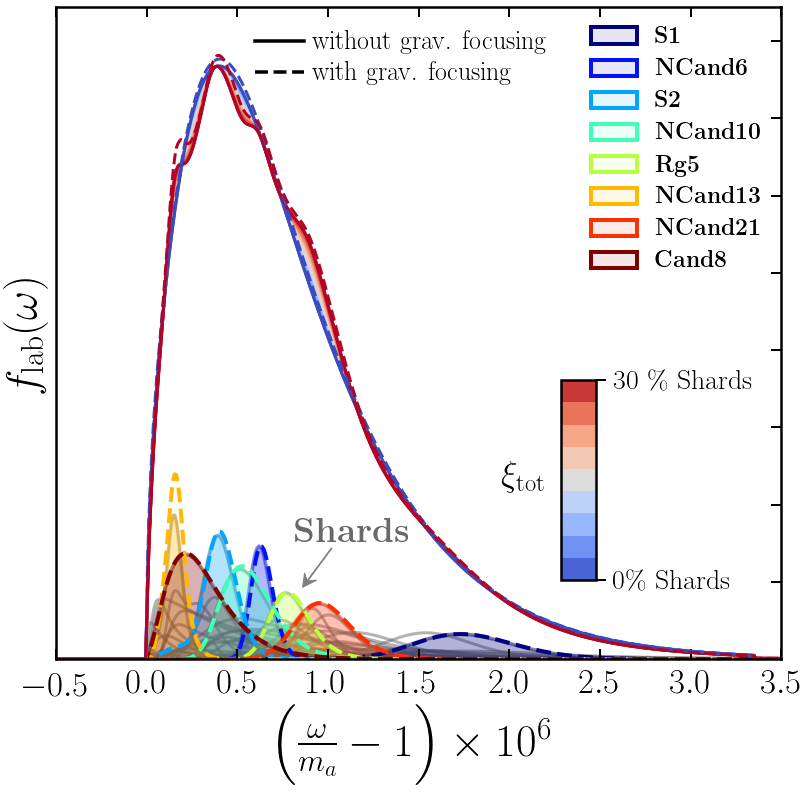

In [33]:
# Figure setup
xlab = r"$\left(\frac{\omega}{m_a} - 1\right) \times 10^6$"
ylab = r"$f_{\rm lab}(\omega)$"
fig,ax = MySquarePlot(xlab,ylab)

# Smooth component
eta_saus = 0.2
fv0_lab = (1-eta_saus)*fv_Iso_lab + eta_saus*fv_Saus_lab
fv0_gf = (1-eta_saus)*fv_Iso_gf + eta_saus*fv_Saus_gf


nshards = shape(shard_label)[0]

ys = domega*dv
x = 1e6*(omega/m_a_s-1)


# Shards with varying xi
n_xi = 10
xi_max = 0.35
xi_vals = linspace(0.0,xi_max,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2_lab = ys*(xi_vals[-1]*sum(fv_lab,0)+(1.0-xi_vals[-1])*fv0_lab)
y2_gf = ys*(xi_vals[-1]*sum(fv_gf,0)+(1.0-xi_vals[-1])*fv0_gf)
fvs_lab = sum(fv_lab,0)
for i in range(0,n_xi):
    xi = xi_vals[i]
    ax.fill_between(x,ys*(xi*fvs_lab+(1-xi)*fv0_lab),y2=y2_lab,color=col[i,:],alpha=0.5)
    ax.plot(x,ys*(xi*fvs_lab+(1-xi)*fv0_lab),'-',color=col[i,:],linewidth=3)
    
    
# Range
ax.plot(x,ys*fv0_lab,'-',color=col[0,:],linewidth=3)
ax.plot(x,y2_lab,'-',color=col[-1,:],linewidth=3)
ax.plot(x,ys*fv0_gf,'--',color=col[0,:],linewidth=3)
ax.plot(x,y2_gf,'--',color=col[-1,:],linewidth=3)

# second "legend" for with/without GF
ax.plot([0.6,0.87],[0.008,0.008], 'k-',linewidth=3.5)
ax.plot([0.6,0.87],[0.0076,0.0076], 'k--',linewidth=3.5)
ax.text(0.91,0.008-0.0001,'without grav. focusing',fontsize=26)
ax.text(0.91,0.0076-0.0001,'with grav. focusing',fontsize=26)

# Plot individual streams
for i in range(0,nshards):
    ax.plot(x,ys*fv_lab[i,:],color='dimgray',alpha=0.5,linewidth=3,zorder=0)

nex = 8
#sortw = argsort(shard_weights)
sortw = argsort(amax(fv_lab,axis=1))
Examples = [shard_label[i] for i in flipud(sortw[-(nex):])]
if 'S1' in Examples:
    Examples.remove('S1')
    Examples = append('S1',Examples)
else:
    Examples = append('S1',Examples)
    Examples = Examples[0:-1]

col_ex = (cm.jet(linspace(0,1,nex)))
    
for i in range(0,size(Examples)):
    j = shard_label.index(Examples[i])
    ax.fill_between(x,ys*fv_lab[j,:],color=col_ex[i,:],lw=4,alpha=0.3,zorder=1) 
    ax.plot(x,ys*fv_gf[j,:],'--',color=col_ex[i,:],lw=4,zorder=1)
    ax.fill_between([-1,-1],[-1,-3],facecolor=col_alpha(col_ex[i,:]),edgecolor=col_ex[i,:],lw=4,label=r'{\bf '+Examples[i]+r'}',zorder=1)

# Legend lines
leg = ax.legend(loc='upper right',fontsize=23,edgecolor='k')
leg.get_frame().set_linewidth(0)
 
    
# Plot fiddling
ax.set_xlim(left=-0.5,right=3.5)
ax.set_ylim(bottom=0.0,top=amax(fv0_lab*ys)*1.1)
ax.tick_params(which='major',direction='in',width=2,length=10,left=False,top=True,pad=10,labelleft=False)
plt.xticks(fontsize=35)
plt.gcf().text(0.38,0.26,r'{\bf Shards}',fontsize=35,color='dimgray')
ax.arrow(0.38, 0.17, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')



# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-30, 0, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=28) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.6,0.32,r'$\xi_{\rm tot}$',fontsize=35,color='k')


# Save figure
plt.show()
pltname = 'Shards_axionspectrum'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [43]:
[shard_label[i] for i in Examples[i]]

TypeError: list indices must be integers, not str